In [74]:
import numpy as np
import pandas as pd
import re
import pdb
from matplotlib import pyplot as plt
from scipy import stats as st
%matplotlib inline

In [2]:
gifts=pd.read_csv('gifts.csv')

In [3]:
gifts.shape

(7166, 1)

In [4]:
gifts=gifts.assign(gift=gifts.GiftId.apply(lambda x: x.split('_')[0]).apply(lambda x: re.sub("s$","",x)))

In [5]:
set(gifts.gift)

{'ball', 'bike', 'block', 'book', 'coal', 'doll', 'glove', 'horse', 'train'}

In [6]:
gifts.groupby('gift').count()

,GiftId
gift,
ball,1100
bike,500
block,1000
book,1200
coal,166
doll,1000
glove,200
horse,1000
train,1000


In [7]:
def pound_weighted_gifts():
    
    weights = {'horse' : max(0, np.random.normal(5,2,1)[0]),

    'ball' : max(0, 1 + np.random.normal(1,0.3,1)[0]),

    'bike' : max(0, np.random.normal(20,10,1)[0]),

    'train' : max(0, np.random.normal(10,5,1)[0]),

    'coal' : 47 * np.random.beta(0.5,0.5,1)[0],

    'book' : np.random.chisquare(2,1)[0],

    'doll' : np.random.gamma(5,1,1)[0],

    'block' : np.random.triangular(5,10,20,1)[0],

    'gloves' : 3.0 + np.random.rand(1)[0] if np.random.rand(1) < 0.3 else np.random.rand(1)[0]}

    weights = pd.DataFrame(weights,index=['lbs']).T

    adjcolnames=pd.DataFrame(weights.index.tolist(),index=weights.index,columns=['colnames']).colnames.apply(lambda x: re.sub("s$","",x))

    weights.index=adjcolnames
    
    return weights

In [8]:
def pound_weighted_gifts(gifttype):
    
    weights = {'horse' : max(0, np.random.normal(5,2,1)[0]),

    'ball' : max(0, 1 + np.random.normal(1,0.3,1)[0]),

    'bike' : max(0, np.random.normal(20,10,1)[0]),

    'train' : max(0, np.random.normal(10,5,1)[0]),

    'coal' : 47 * np.random.beta(0.5,0.5,1)[0],

    'book' : np.random.chisquare(2,1)[0],

    'doll' : np.random.gamma(5,1,1)[0],

    'block' : np.random.triangular(5,10,20,1)[0],

    'glove' : 3.0 + np.random.rand(1)[0] if np.random.rand(1) < 0.3 else np.random.rand(1)[0]}
    
    return weights[gifttype]

In [100]:
weights=gifts.gift.apply(pound_weighted_gifts)

In [7]:
weight_dist=pound_weighted_gifts()
for i in range(100):
    weight_dist=weight_dist.append(pound_weighted_gifts())
len(set(weight_dist.index.values))

9

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

In [10]:
def plot_weights(x,bins):
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('freq')
    ax1.hist(np.ravel(x),bins=bins,histtype='step')

    x.sort()

    ax2 = ax1.twinx()
    ax2.set_ylabel('prob')
    ax2.plot(np.ravel(x),st.norm.pdf(np.ravel(x),loc=np.mean(x),scale=np.std(x)),'--k')
    plt.show()

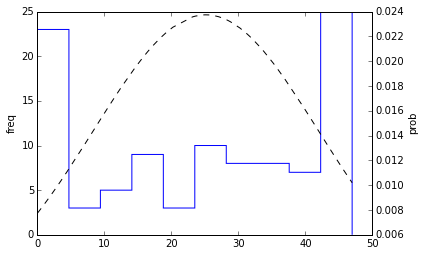

In [10]:
plot_weights(weight_dist.loc['coal',].iloc[:,0].tolist(),10)

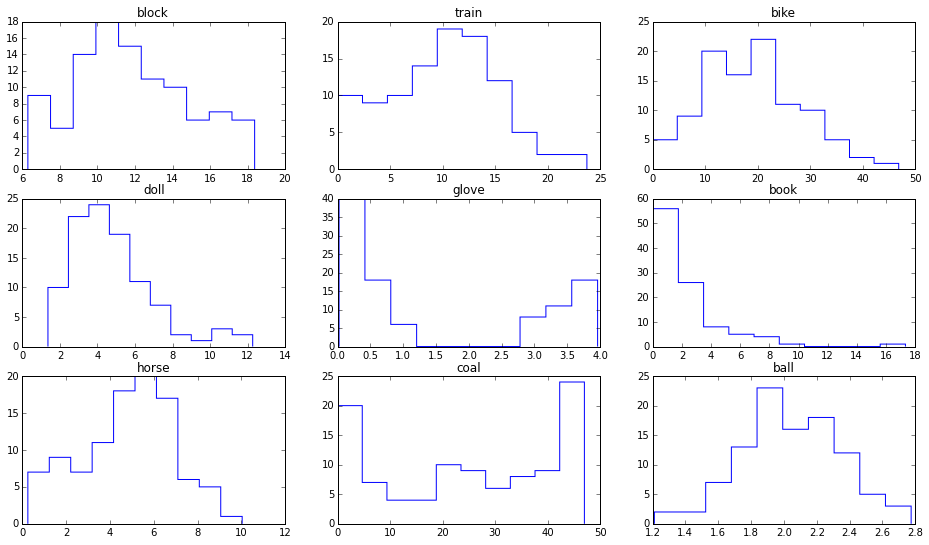

In [10]:
j=1
for i in set(weight_dist.index.values):
    plt.subplot(3,3,j)
    plt.hist(weight_dist.loc[i,:].values,bins=10,histtype='step')
    plt.title(i)
    j+=1
plt.show()

## a bag

In [11]:
class bag:
    def __init__(self,gifts=None):
        self.gifts, self.num, self.lbs, self.weight = [], 0, [], 0
        if gifts is not None:
            self.gifts=gifts.GiftId.tolist()
            self.lbs=gifts.lbs.tolist()
            self.number()
            self.weigh()
    def empty(self):
        self.gifts.pop()
        self.lbs.pop()
        self.number()
        self.weigh()
    def fill(self,gifts):
        self.gifts.append(gifts.GiftId)
        self.lbs.append(gifts.lbs)
        self.number()
        self.weigh()
    def number(self):
        self.num=len(self.gifts)
    def weigh(self):
        self.weight=np.sum(self.lbs)

## a consignment of bags

In [81]:
class consignment:
    def __init__(self, bags=None):
        self.inventory, self.items, self.bag_items, self.num, self.weight = [], [], [], 0, 0
        if bags is not None:
            for bag1 in bags:
                self.addbag(bag1)
    def addbag(self,bag1):
        if (bag1.weight<=50) and (bag1.num>=3):
            self.inventory.append(bag1)
            if len(self.inventory)>1000:
                lbs=[bag1.weight for bag1 in self.inventory]
                discount=lbs.index(np.min(lbs))
                del self.inventory[discount]
                #lbs.sort(reverse=True)
                #lbs=lbs[0:999]
                #self.inventory=[bag1 for bag1 in self.inventory if bag1.weight in lbs]
            self.manifest()
    def manifest(self):
        self.items, self.bag_items, self.num, self.weight = [], [], 0, 0
        for bag1 in self.inventory:
            self.items.extend(bag1.gifts)
            self.bag_items.append(" ".join([j for j in bag1.gifts]))
            self.num+=bag1.num
            self.weight+=bag1.weight

## creating a consignment

#### fill all bags

In [13]:
def bagallbags(gifts):
    picked, con1 = [], consignment()
    for i in range(1000):
        bag1, j = bag(), 0
        while (not(np.all(gifts.index.isin(picked)))) and (j<10):
            pick=np.random.choice(gifts[~gifts.index.isin(picked)].index.tolist(),size=1)[0]
            picked.append(pick)
            bag1.fill(gifts.iloc[pick])
            if bag1.weight>50:
                bag1.empty()
                picked.pop()
                if bag1.num>=3:
                    break
            j+=1
        con1.addbag(bag1)
    return con1

#### bag all gifts

In [14]:
def bagallgifts(gifts):
    i, picked, con1 = 0, [], consignment()
    for i in range(gifts.shape[0]):
        bag1, j = bag(), 0
        while (not(np.all(gifts.index.isin(picked)))) and (j<10):
            pick=np.random.choice(gifts[~gifts.index.isin(picked)].index.values,size=1)[0]
            picked.append(pick)
            bag1.fill(gifts.iloc[pick])
            if bag1.weight>50:
                bag1.empty()
                picked.pop()
                if bag1.num>=3:
                    break
            j+=1
        con1.addbag(bag1)
        if len(picked)==gifts.shape[0]:
            break
    return con1

#### bag all gifts adjusting bag weight with Standard Error of Mean

In [101]:
def varadjbagallgifts(gifts,adj):
    picked, con1 = [], consignment()
    while (not(np.all(gifts.GiftId.isin(picked)))):
        #pdb.set_trace()
        bag1, j = bag(), 0
        while (not(np.all(gifts.GiftId.isin(picked)))) and (j<10):
            pick=np.random.choice(gifts[~gifts.GiftId.isin(picked)].index.values,size=1)[0]
            picked.append(gifts.GiftId.iloc[pick])
            bag1.fill(gifts.iloc[pick])
            mu=np.mean(bag1.lbs)
            SEM=np.std(bag1.lbs)/np.sqrt(bag1.num)
            varadjbagweight=(mu+adj*SEM)*bag1.num
            if bag1.num>3 and varadjbagweight>50:
                bag1.empty()
                picked.pop()
                j+=1
        con1.addbag(bag1)
    return con1

#### bag similar gifts adjusting bag weight with Standard Error of Mean

#### testing all gifts

In [16]:
#gifts2=gifts.assign(lbs=gifts.merge(pound_weighted_gifts(),left_on='gift',right_index=True).loc[:,'lbs'])

In [85]:
gifts2=gifts.assign(lbs=weights)

In [92]:
con0 = varadjbagallgifts(gifts2,2)
len(con0.inventory), con0.num, con0.weight

(1000, 5375, 34397.834227129097)

#### testing similar gifts

#### list of consigments

In [110]:
conlist = gifts2.groupby('gift').apply(lambda x: varadjbagallgifts(x.reset_index(drop=True),2))

#### bagged gifts

In [111]:
allpicked=[]
[allpicked.extend(i.items) for i in conlist.tolist()]
len(allpicked)

6613

#### creating a big consignment

In [112]:
con0=consignment()
[con0.addbag(j) for i in conlist.tolist() for j in i.inventory]
len(con0.inventory), con0.num, con0.weight

(1000, 6600, 37902.384173243925)

#### creating a big inventory

In [ ]:
inventory=con0.inventory

#### baging unpicked

In [115]:
con0=consignment()
con1=varadjbagallgifts(gifts2[~gifts2.GiftId.isin(allpicked)].reset_index(drop=True),2)

(1000, 6568, 38315.754999533718)

#### adding to inventory

In [ ]:
inventory.extend(con1.inventory)
[con0.addbag(i) for i in inventory]

In [ ]:
len(con0.inventory), con0.num, con0.weight

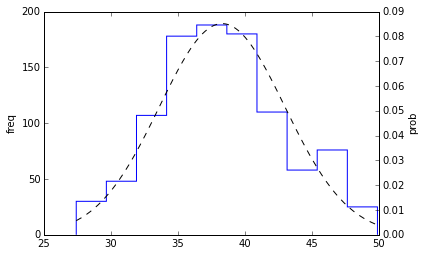

In [122]:
plot_weights([con0.inventory[i].weight for i in range(len(con0.inventory))],10)

In [123]:
pd.DataFrame(con0.bag_items,columns=['Gifts']).to_csv('submission2_0110.csv',index=False)

## Natural selection

In [23]:
#weights=pound_weighted_gifts()

In [97]:
def selection(cutoff,adj,gifts=gifts,weights=weights):
    #gifts2=gifts.assign(lbs=gifts.merge(weights,left_on='gift',right_index=True).loc[:,'lbs'])
    gifts2=gifts.assign(lbs=weights)
    
    con1 = consignment()

    for j in range(100):
        if (len(con1.inventory)<1000) and (con1.num<gifts.shape[0]):
            #con0=bagallgifts(gifts2)
            con0=varadjbagallgifts(gifts2,adj)
            [con1.addbag(con0.inventory[i]) for i in range(len(con0.inventory)) if con0.inventory[i].weight>=cutoff]
            print(con1.weight)
            gifts2=gifts2[~gifts2.GiftId.isin(con1.items)].reset_index(drop=True)
    return(con1)

In [98]:
con1=selection(40,2)
len(con1.inventory), con1.num, con1.weight

6186.89197668
10465.8174973
14715.3970304
17555.4747006
19999.7923744
22136.4721305
23446.5698396
24766.1493739
26212.4111202
26982.0259038
27583.6411506
28052.2661455
28962.0548872
29611.481176
30046.7434517
30510.5949425
30929.4952235
31430.837226
31818.4530404
32153.5274947
32449.3053098
32717.6574051
32886.413998
33218.1202689
33650.3286152
34077.012994
34289.7938766
34500.119241
34713.7326827
34970.5015738
35228.758398
35311.0231159
35596.2465603
35717.8106556
35883.8265786
35925.0971458
36177.6429405
36466.2947093
36588.6074795
36752.1100859
36834.6816921
36834.6816921
37042.2076947
37167.4133009
37291.6143132
37547.3656265
37834.6876322
38079.7986595
38163.2965068
38284.9822203
38538.9804395
38580.3104773
38662.179727
38744.9215059
38988.9455833
39032.3832895
39155.7038692
39361.2225593
39443.2023533
39486.4151685
39568.8793575
39691.1605087
39691.1605087
39813.8025292
39894.9385312
40101.5255233
40224.4036515
40348.4789778
40348.4789778
40472.4285852
40564.0750728
40685.441902


(988, 4528, 42752.545973720436)

In [99]:
pd.DataFrame(con1.bag_items,columns=['Gifts']).to_csv('submission12_3009.csv',index=False)

## Simulated Annealing

In [31]:
def anneal(T1,cutoff,rigor,gifts=gifts):
    gifts=pounds(gifts)
    con0=baggingallbags(gifts)
    retries=[]
    for dT in range(T1):
        T2=T1-dT
        cutoff+=dT*rigor/T1
        con1=baggingallbags(gifts)
        delta=con1.weight-con0.weight
        p=np.exp(delta/T2)
        if (delta>0) or (p>cutoff):
            con0=con1
        else:
            retries.insert(0,dT)
        if len(retries)>10:
            if np.sum([retries[i]-retries[i+1] for i in range(10)])==10:
                print("converged at:",con0.weight)
                break
    return con0

In [ ]:
con=anneal(T1=1000,cutoff=0.1,rigor=0.8)

In [31]:
def anneal(steps,pcutoff,rigor,wcutoff,gifts=gifts,weights=weights,T1=50):
    #N=gifts.merge(weights,left_on='gift',right_index=True).loc[:,'lbs'].sum()
    N=weights.sum()
    
    con0=selection(wcutoff,gifts,weights)
    retries=[]
    
    for dT in np.linspace(wcutoff,T1,steps):
        T2=T1-dT
        pcutoff+=dT*rigor/T1
        con1=selection(dT,gifts,weights)
        delfitness=(con1.weight-con0.weight)/N
        p=np.exp(delfitness/T2)
        if (delfitness>0) or (p>pcutoff):
            con0=con1
        else:
            retries.insert(0,dT)
        if len(retries)>10:
            if np.sum([retries[i]-retries[i+1] for i in range(10)])==10*step:
                print("converged at:",con0.weight)
                break
    return con0

In [32]:
con=anneal(steps=25,pcutoff=0.5,rigor=0.5,wcutoff=40)

36458.9207813
46019.3959188
37986.4754695
46099.4143196
36159.7794561
45850.1848422
46504.9742717
37098.6188651
46249.2538628
46535.4487269
36459.4967311
45426.764144
46688.698485
35245.7872429
44917.8732814
46722.6950021
33459.3967255
45028.5890736
46675.6820015
31726.4215818
43449.2739239
46963.2872399
30657.5260426
42265.8562287
47066.0027483
31384.0760512
41201.6882563
46912.3709271
47211.51831
28046.5477808
40337.8791564
45847.4787664
47376.9310229
28511.9847641
41981.7781592
46642.2538829
47565.0387739
26307.1705147
39652.863381
45412.1880372
47647.7496545
26559.8348893
37534.7313763
44083.1513233
46947.2854292
47830.8835456
24842.5035927
36209.3280438
42914.2579364
46071.649709
47884.6638231
21357.6629056
34941.7151898
41162.8890763
45312.9380652
47771.9668831
48169.882167
18871.4849009
31438.302325
39099.9818041
43306.4194995
45625.0173775
47322.8811714
48302.7847895
18781.2149894
29878.7155444
38112.0164171
42323.4578729
45563.6667951
46829.8416477
48091.0812194
48441.1495414


In [33]:
len(con.inventory), con.num, con.weight

(999, 6909, 49535.162151094963)

In [34]:
pd.DataFrame(con.bag_items,columns=['Gifts']).to_csv('submission2_2909.csv',index=False)

## Sampling distribution of gifts

In [35]:
def samplegifts(size,gifts=gifts,weights=weights):
    inventory, picked = [], []

    #gifts2=gifts.assign(lbs=gifts.merge(weights,left_on='gift',right_index=True).loc[:,'lbs'])
    gifts2=gifts.assign(lbs=weights)

    while np.sum(~gifts2.index.isin(picked))>=size:
        pick=np.random.choice(gifts2[~gifts2.index.isin(picked)].index.values,size=size)
        inventory.append(gifts2.loc[gifts2.index.isin(pick),'lbs'].mean())
        picked.extend(pick)
    return inventory

In [53]:
inventory=samplegifts(3)
np.std(inventory)

4.1779285749502675

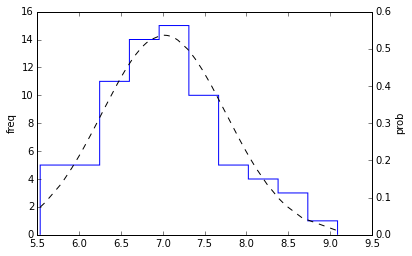

In [50]:
plot_weights(inventory,10)

## Cluster weights (k < len(set(gifts.gift)))

## weight Baised choice